# User Segmentation & Value Analysis (RFM Model)
Objectives:
- Segment e-commerce users based on RFM metrics
- Analyze value, satisfaction, and latency characteristics across different user segments
- Provide characteristics and business basis for subsequent churn prediction/precision marketing

In [1]:
# read data from sql:view_user_behavior
import pandas as pd
from src.utils.db import get_engine

# build connection with database
engine = get_engine()

# from view_user_behavior read "Aggregated behavioral data by user"
sql = "SELECT * FROM view_user_behavior"
df = pd.read_sql(sql, engine)

# close connection
engine.dispose()

# check head 5 row
df.head()

,unique_user_id,city,state,order_count,total_spent,avg_order_value,last_purchase_date,days_since_last_purchase,first_purchase_date,customer_lifetime_days
0,0000366f3b9a7992bf8c76cfdf3221e2,cajamar,SP,1,141.90,141.90,2018-05-10 10:56:27,2851,2018-05-10 10:56:27,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,SP,1,27.19,27.19,2018-05-07 11:11:27,2854,2018-05-07 11:11:27,0
2,0000f46a3911fa3c0805444483337064,sao jose,SC,1,86.22,86.22,2017-03-10 21:05:03,3277,2017-03-10 21:05:03,0
3,0000f6ccb0745a6a4b88665a16c9f078,belem,PA,1,43.62,43.62,2017-10-12 20:29:41,3061,2017-10-12 20:29:41,0
4,0004aac84e0df4da2b147fca70cf8255,sorocaba,SP,1,196.89,196.89,2017-11-14 19:45:42,3028,2017-11-14 19:45:42,0


In [2]:
# check the data
print("Shape", df.shape)    # how much row\columns
print("\nInfo:", df.info()) # type of every column\if have null value

print("\nDescribe (Columns related to RFM):")
print(df[['order_count', 'total_spent', 'days_since_last_purchase']].describe())

print("\nMissing values:", df.isnull().sum())

Shape (96219, 10)
<class 'pandas.DataFrame'>
RangeIndex: 96219 entries, 0 to 96218
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   unique_user_id            96219 non-null  str           
 1   city                      96219 non-null  str           
 2   state                     96219 non-null  str           
 3   order_count               96219 non-null  int64         
 4   total_spent               95539 non-null  float64       
 5   avg_order_value           95539 non-null  float64       
 6   last_purchase_date        96219 non-null  datetime64[us]
 7   days_since_last_purchase  96219 non-null  int64         
 8   first_purchase_date       96219 non-null  datetime64[us]
 9   customer_lifetime_days    96219 non-null  int64         
dtypes: datetime64[us](2), float64(2), int64(3), str(3)
memory usage: 7.3 MB

Info: None

Describe (Columns related to RFM):
        order_c

In [3]:
# Clean up R/F/M fields(recency\frequency\monetary)
df_rfm = df.copy()

# Retain only: Users who have purchased at least once
df_rfm = df_rfm[df_rfm['order_count'] > 0].copy()

print("After filtering users with order_count > 0:")
print(df_rfm[['order_count', 'total_spent', 'days_since_last_purchase']].describe())

After filtering users with order_count > 0:
        order_count   total_spent  days_since_last_purchase
count  96219.000000  95539.000000              96219.000000
mean       1.033486    165.833359               2979.230173
std        0.210763    228.095176                153.439029
min        1.000000      9.590000               2691.000000
25%        1.000000     63.100000               2855.000000
50%        1.000000    107.850000               2960.000000
75%        1.000000    182.910000               3089.000000
max       17.000000  13664.080000               3464.000000


In [4]:
# Unified naming convention
df_rfm.rename(columns = {
    'days_since_last_purchase': 'recency',
    'order_count': 'frequency',
    'total_spent' : 'monetary'
}, inplace=True)

df_rfm[['unique_user_id', 'recency', 'frequency', 'monetary']].head()

,unique_user_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2851,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2854,1,27.19
2,0000f46a3911fa3c0805444483337064,3277,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,3061,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,3028,1,196.89


In [5]:
df_rfm[['recency', 'frequency', 'monetary']].isna().sum()

recency        0
frequency      0
monetary     680
dtype: int64

In [6]:
df_rfm = df_rfm.dropna(
    subset=['recency', 'frequency', 'monetary']
).copy()
# Recency scoring: The more recent the event, the higher the score.
'''
qcut will be divided into 5 parts according to the value from smallest to larger, here directly specify the tag [5,4,3,2,1], so that the most recent one gets 5 points
'''
df_rfm['R_score'] = pd.qcut(
    df_rfm['recency'],
    5,
    labels = [5, 4, 3, 2, 1]
).astype(int)

# Frequency scoring: more bigger, the higher score
'''
Rank first, then qcut to avoid too many duplicate values causing qcut errors
'''
df_rfm['F_score'] = pd.qcut(
    df_rfm['frequency'].rank(method='first'),
    5,
    labels=[5, 4, 3, 2, 1]
).astype(int)

# Monetary:bigger, better
df_rfm['M_score'] = pd.qcut(
    df_rfm['monetary'].rank(method='first'),
    5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

# Simple total RFM score (3~15)
df_rfm['RFM_score'] = (
    df_rfm['R_score'] + df_rfm['F_score'] + df_rfm['M_score']
)

df_rfm[['unique_user_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']].head(20)

,unique_user_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2851,1,141.90,4,5,4,13
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2854,1,27.19,4,5,1,10
2,0000f46a3911fa3c0805444483337064,3277,1,86.22,1,5,2,8
3,0000f6ccb0745a6a4b88665a16c9f078,3061,1,43.62,2,5,1,8
4,0004aac84e0df4da2b147fca70cf8255,3028,1,196.89,2,5,4,11
5,0004bd2a26a76fe21f786e4fbd80607f,2886,1,166.98,4,5,4,13
6,00050ab1314c0e55a6ca13cf7181fecf,2871,1,35.38,4,5,1,10
7,00053a61a98854899e70ed204dd4bafe,2922,1,419.18,3,5,5,13
8,0005e1862207bf6ccc02e4228effd9a0,3283,1,150.12,1,5,4,10
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2910,1,129.76,4,5,3,12


In [7]:
# Select the features that will be used for clustering.
features = ['recency', 'frequency', 'monetary']

# standardscaler(All variables become the same scale.)
from sklearn.preprocessing import StandardScaler

x = df_rfm[features]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

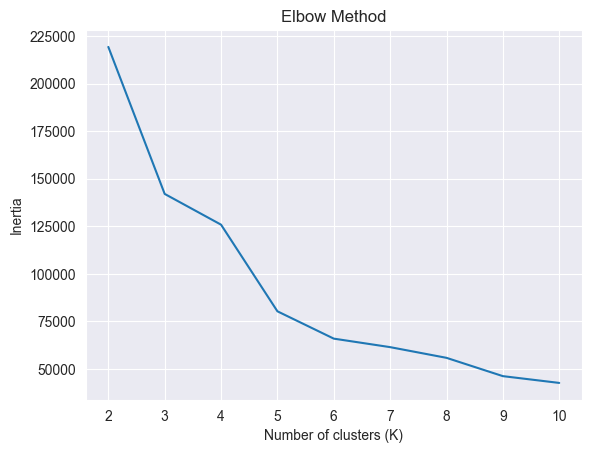

In [8]:
# K value
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Elbow Method map analysis
The Elbow curve shows a continuous decrease in inertia from K=2 to K=5, with a particularly noticeable drop between K=4 and K=5. After K=5, the rate of decrease slows significantly and the curve begins to flatten.

This suggests that adding clusters beyond K=5 yields diminishing returns in terms of reducing within-cluster variance.

Therefore, from an inertia minimization perspective, K=5 appears to be a potential elbow point.

In [9]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.4028
K=3, Silhouette Score=0.4557
K=4, Silhouette Score=0.3613
K=5, Silhouette Score=0.4177
K=6, Silhouette Score=0.4361
K=7, Silhouette Score=0.3790
K=8, Silhouette Score=0.3933
K=9, Silhouette Score=0.3957
K=10, Silhouette Score=0.3989


# Cluster Selection Summary (Elbow + Silhouette Combined)
Based on the Silhouette evaluation from K=2 to K=10, the highest score occurs at K=3 (0.4557), indicating the clearest structural separation and strongest cluster cohesion.

Although higher K values such as K=5 (0.4177) and K=6 (0.4361) provide additional segmentation granularity, their separation quality is slightly weaker compared to K=3. Scores beyond K=6 begin to stabilize around 0.38–0.39, suggesting diminishing structural improvement and potential over-segmentation.

Combined with the Elbow analysis, which shows noticeable inertia reduction around K=5, we observe a trade-off between statistical compactness and structural clarity.

From a purely statistical standpoint, K=3 is the most robust segmentation choice.
However, depending on business needs for finer differentiation, K=5 may serve as a practical alternative.

In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_rfm['cluster'] = kmeans.fit_predict(x_scaled)

In [11]:
# how many person in each cluster
df_rfm['cluster'].value_counts().sort_index()

cluster
0    39363
1    53291
2     2885
Name: count, dtype: int64

In [12]:
# rfm.mean for each cluster
cluster_profile = df_rfm.groupby('cluster')[
    ['recency', 'frequency', 'monetary']
].mean().round(2)

cluster_profile

,recency,frequency,monetary
cluster,,,
0,3128.80,1.00,162.27
1,2868.59,1.00,159.81
2,2961.04,2.11,325.69


In [13]:
# cluster_size
cluster_size = df_rfm['cluster'].value_counts(normalize=True).sort_index()
cluster_size

cluster
0    0.412010
1    0.557793
2    0.030197
Name: proportion, dtype: float64

In [17]:
# Combine cluster size & RFM profile into one table
cluster_profile_with_size = cluster_profile.copy()
cluster_profile_with_size["user_count"] = df_rfm["cluster"].value_counts().sort_index()
cluster_profile_with_size["user_ratio"] = df_rfm["cluster"].value_counts(normalize=True).sort_index().round(4)
cluster_profile_with_size

,recency,frequency,monetary,user_count,user_ratio
cluster,,,,,
0,3128.80,1.00,162.27,39363,0.4120
1,2868.59,1.00,159.81,53291,0.5578
2,2961.04,2.11,325.69,2885,0.0302


In [18]:
# Map cluster id to human-readable segment names
cluster_labels = {
    0: "Lapsed Single-Purchase Users",
    1: "Recent Single-Purchase Users",
    2: "High-Value Repeat Customers"
}

df_rfm["segment"] = df_rfm["cluster"].map(cluster_labels)

df_rfm[["unique_user_id", "cluster", "segment", "recency", "frequency", "monetary"]].head(10)

,unique_user_id,cluster,segment,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,Recent Single-Purchase Users,2851,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,Recent Single-Purchase Users,2854,1,27.19
2,0000f46a3911fa3c0805444483337064,0,Lapsed Single-Purchase Users,3277,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,0,Lapsed Single-Purchase Users,3061,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,0,Lapsed Single-Purchase Users,3028,1,196.89
5,0004bd2a26a76fe21f786e4fbd80607f,1,Recent Single-Purchase Users,2886,1,166.98
6,00050ab1314c0e55a6ca13cf7181fecf,1,Recent Single-Purchase Users,2871,1,35.38
7,00053a61a98854899e70ed204dd4bafe,1,Recent Single-Purchase Users,2922,1,419.18
8,0005e1862207bf6ccc02e4228effd9a0,0,Lapsed Single-Purchase Users,3283,1,150.12
9,0005ef4cd20d2893f0d9fbd94d3c0d97,1,Recent Single-Purchase Users,2910,1,129.76


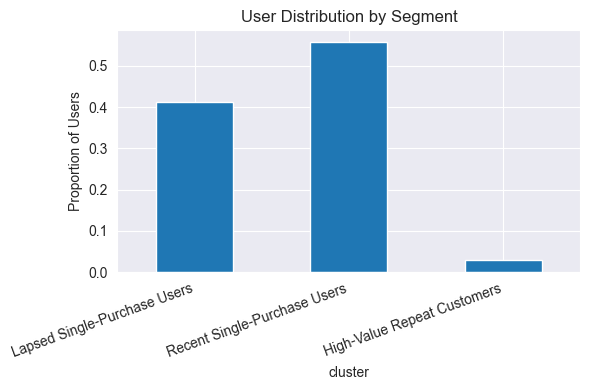

In [20]:
import matplotlib.pyplot as plt

# Visualization 1: Proportion of users in each segment
plt.figure(figsize=(6, 4))
cluster_profile_with_size["user_ratio"].plot(kind="bar")
plt.xticks(
    range(len(cluster_profile_with_size)),
    [cluster_labels[i] for i in cluster_profile_with_size.index],
    rotation=20,
    ha="right"
)

plt.ylabel("Proportion of Users")
plt.title("User Distribution by Segment")
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

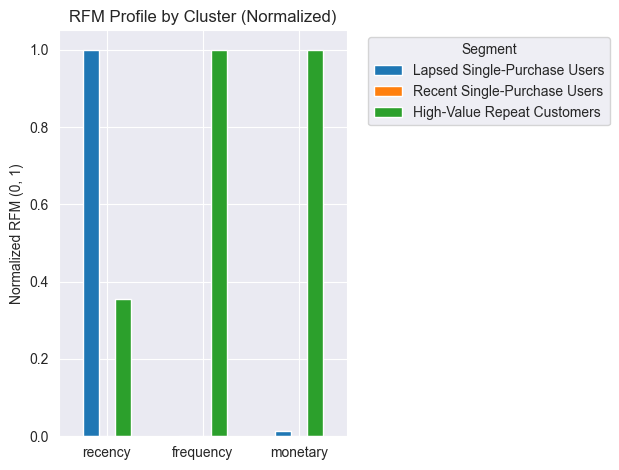

In [21]:
# Visualization 2: Standardized RFM images for each segment
rfm_profile_norm =(cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

plt.figure(figsize=(8, 5))
rfm_profile_norm.T.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Normalized RFM (0, 1)")
plt.title("RFM Profile by Cluster (Normalized)")
plt.legend(
    [cluster_labels[i] for i in rfm_profile_norm.index],
    title="Segment",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

,recency,frequency,monetary
cluster,,,
0,1.00000,0.0,0.01483
1,0.00000,0.0,0.00000
2,0.35529,1.0,1.00000


# Segment Definition & Business Interpretation

**Cluster 1 – Recent Single-Purchase Users (~55.8%)**
  - Characteristics: most recent purchases (lowest recency), single-order behavior, medium spend.
  - Business view: newcomers or recently activated users with limited purchase history.
  - Strategy: welcome offers, cross-sell recommendations, onboarding journeys to drive second purchase.

**Cluster 0 – Lapsed Single-Purchase Users (~41.2%)**
  - Characteristics: long time since last purchase (highest recency), still mostly single-order, moderate spend.
  - Business view: churn-risk / sleeping users who have purchased once but did not come back.
  - Strategy: reactivation campaigns, time-limited discounts, win-back emails highlighting category they bought before.

**Cluster 2 – High-Value Repeat Customers (~3.0%)**
  - Characteristics: significantly higher frequency and monetary value, recency in the middle range.
  - Business view: core loyal customers contributing disproportionately to GMV.
  - Strategy: loyalty programs, VIP service, early access to promotions, personalized recommendations.

In [14]:
# find frequency always are 1
df_rfm['frequency'].describe()

count    95539.000000
mean         1.033630
std          0.211235
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: frequency, dtype: float64

In [15]:
df_rfm['frequency'].value_counts().sort_index()

frequency
1     92661
2      2637
3       194
4        28
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64